## Imports

In [1]:
import os

import spacy
from spacy import displacy

import random
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from spacy.training.example import Example

In [2]:
TRAIN_DATA_PATH = os.path.abspath("../../data/datasets/ner-swiss-receipts-train.json")  # Path to your training data file
TEST_DATA_PATH = os.path.abspath("../../data/datasets/ner-swiss-receipts-test.json")  # Path to your training data file

OUTPUT_DIR = os.path.abspath("../models/receipt-item-details-ner-v01")  # TODO: make sure to use a new version
ITERATIONS = 30  # Number of training iterations
BATCH_SIZE = 8  # Batch size for training
DROPOUT = 0.5  # Dropout rate

## Preprocessing

### Load Dataset

In [3]:
with open(TRAIN_DATA_PATH, "r", encoding="utf-8") as file:
    dataset = json.load(file)

### Reformat for Spacy & Remove unwanted Entities

In [4]:
train_data = []
for entry in dataset:
    text = entry["text"]
    entities = [entity for entity in entry["entities"] if entity[2] != 'RECEIPT_ITEM']
    train_data.append((text, {"entities": entities}))

In [5]:
print("Sample Training Data:")
sample_text, sample_annotaiton = train_data[0]
print("-----------------------------------------")
print(sample_text)
print("-----------------------------------------")
for ent in sample_annotaiton.get("entities"):
    print(f'Entity-Type: {ent[2]}, Entity text: {sample_text[ent[0]:ent[1]]}')

Sample Training Data:
-----------------------------------------
HAMNUGLU GmbH
HERTENSTEIN

Hertensteinstrasse 32

6004 Luzern

Tel 041 419 71 51
RER

#CS0 Rechnungsnummer: 36 POSEJ Order: el
KASSE 32- 2071272024 14:23:55

ANZ ARTIKEL GESAMT "
1MeChicken 6.90 M
ı MM 9 McNuggets f 15.800. Ep
19 Nucpets 2
1 Cocktail Sauce

. 1 Potatoes Sauce
1 Hen ohne Ksäure 0.5 2
1 Medium Pommes Frite ed
1 Cocktail Sauce en

Subtotal 2.10 u
Discount: i -1.30 Be
INNEN TOTAL 21.40 wo
VISA 210 0

st.Nr. CHE - 449.055.085 MWST ] 0
SATZ BRUTTO MWST.
incl. MWST  8.10 21.40 1.60

 Kundenbeleg

Buchung
. Visa payWave contact less

4323 22XX XXXX 1361

20.12.2024 14:23:41
u Trm-Id: 10138349
AID: 40000000031010
Irx. Seg-Cnt: Mo

..... Trx. Ref-No: .

Auth, Code:

-----------------------------------------
Entity-Type: RECEIPT_ITEM_QUANTITY, Entity text: 1
Entity-Type: RECEIPT_ITEM_NAME, Entity text: MeChicken
Entity-Type: RECEIPT_ITEM_PRICE, Entity text: 6.90
Entity-Type: RECEIPT_ITEM_NAME, Entity text: 9 McNugget

## Model Definition

Load an emtpy spacy model for specific language

In [6]:
# For a blank model, or replace with spacy.load("en_core_web_sm")
nlp = spacy.blank("de")

### Add Named-Entity Recognition Component

In [7]:
if "ner" not in nlp.pipe_names:
    ner = nlp.add_pipe("ner", last=True)
else:
    ner = nlp.get_pipe("ner")

### Add Labels to Model

In [8]:
for _, annotations in train_data:
    for ent in annotations.get("entities"):
        ner.add_label(ent[2])

### Spacy Examples

In [9]:
examples = []

for text, annotations in train_data:
    try:
        examples.append(Example.from_dict(nlp.make_doc(text), annotations))
    except Exception as e:
        print('!!ERROR!!' + str(e))
        continue

!!ERROR!![E103] Trying to set conflicting doc.ents: '(286, 287, 'RECEIPT_ITEM_QUANTITY')' and '(286, 290, 'RECEIPT_ITEM_PRICE')'. A token can only be part of one entity, so make sure the entities you're setting don't overlap. To work with overlapping entities, consider using doc.spans instead.
!!ERROR!![E103] Trying to set conflicting doc.ents: '(254, 255, 'RECEIPT_ITEM_QUANTITY')' and '(254, 258, 'RECEIPT_ITEM_PRICE')'. A token can only be part of one entity, so make sure the entities you're setting don't overlap. To work with overlapping entities, consider using doc.spans instead.


/Users/timon/.pyenv/versions/3.10.16/envs/dspro/lib/python3.10/site-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "HAMNUGLU GmbH
HERTENSTEIN

Hertensteinstrasse 32

..." with entities "[[179, 180, 'RECEIPT_ITEM_QUANTITY'], [180, 189, '...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/Users/timon/.pyenv/versions/3.10.16/envs/dspro/lib/python3.10/site-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Belvedere

— Seerestaurant ———-

Rechnung 54777 21..." with entities "[[85, 86, 'RECEIPT_ITEM_QUANTITY'], [87, 96, 'RECE...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/Users/timon/.pyenv/versions/3.10.16/envs/dspr

### Training

In [10]:
# Disable other pipes during training for efficiency
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
with nlp.disable_pipes(*other_pipes):
    optimizer = nlp.begin_training()
        
    # Training loop
    print("Starting training...")
    for epoch in range(ITERATIONS):
        random.shuffle(examples)
        losses = {}
        for batch in spacy.util.minibatch(examples, size=BATCH_SIZE):
            nlp.update(batch, drop=DROPOUT, losses=losses)
        print(f"Epoch {epoch + 1}/{ITERATIONS}, Loss: {losses['ner']:.4f}")

Starting training...
Epoch 1/30, Loss: 7072.8521
Epoch 2/30, Loss: 2354.8713
Epoch 3/30, Loss: 1703.9056
Epoch 4/30, Loss: 1612.2820
Epoch 5/30, Loss: 1480.2219
Epoch 6/30, Loss: 1346.2645
Epoch 7/30, Loss: 1266.8635
Epoch 8/30, Loss: 1124.0197
Epoch 9/30, Loss: 1046.1372
Epoch 10/30, Loss: 1051.7067
Epoch 11/30, Loss: 980.2461
Epoch 12/30, Loss: 867.5386
Epoch 13/30, Loss: 892.3243
Epoch 14/30, Loss: 820.1414
Epoch 15/30, Loss: 766.0367
Epoch 16/30, Loss: 773.3663
Epoch 17/30, Loss: 690.4933
Epoch 18/30, Loss: 673.3093
Epoch 19/30, Loss: 625.8666
Epoch 20/30, Loss: 560.8406
Epoch 21/30, Loss: 531.8400
Epoch 22/30, Loss: 508.6844
Epoch 23/30, Loss: 488.6778
Epoch 24/30, Loss: 483.6571
Epoch 25/30, Loss: 436.5814
Epoch 26/30, Loss: 425.1562
Epoch 27/30, Loss: 390.0970
Epoch 28/30, Loss: 372.4345
Epoch 29/30, Loss: 374.9224
Epoch 30/30, Loss: 364.1654


### Save Model

In [11]:
# Save the trained model
print(f"Saving model to {OUTPUT_DIR}...")
nlp.to_disk(OUTPUT_DIR)

Saving model to /Users/timon/git/dspro1-receipt-ocr/named-entity-recognition/models/receipt-item-details-ner-v01...


## Evaluation

In [12]:
with open(TEST_DATA_PATH, "r", encoding="utf-8") as file:
    dataset = json.load(file)

In [13]:
test_data = []
for entry in dataset:
    text = entry["text"]
    entities = [entity for entity in entry["entities"] if entity[2] != 'RECEIPT_ITEM']
    test_data.append((text, {"entities": entities}))

In [14]:
def print_confusion_matrix(matrix, labels):
    """
    Prints a confusion matrix as a formatted string.

    Args:
        matrix (list of list of int): Confusion matrix as a 2D list.
        labels (list of str): Labels for the matrix.
    """
    max_label_length = max(len(label) for label in labels)
    padding = max_label_length + 2

    # Print header
    header = " " * padding + " ".join(f"{label:>{padding}}" for label in labels)
    print(f'{"":<15} Predicted Values')
    print(header)

    # Print each row
    for label, row in zip(labels, matrix):
        row_str = " ".join(f"{cell:>{padding}}" for cell in row)
        print(f"{label:>{padding}} {row_str}")

In [15]:
true_positive = []
false_positive = []
false_negative = []

index = 0

for text, annotations in test_data:
    # Process the text
    doc = nlp(text)
    
    # Prepare expected values (y)
    expected_entities = []
    for ent in annotations.get("entities"):    
        if ent[2] != 'RECEIPT_ITEM':
            expected_entities.append(text[ent[0]:ent[1]])

    # Print recognized entities
    for ent in doc.ents:
        if ent.text in expected_entities:
            true_positive.append(ent.text)
            expected_entities.remove(ent.text)
        else:
            false_positive.append(ent.text)
            
    false_negative.extend(expected_entities)
    
# Example usage
labels = ["Entity", "No Entity"]
confusion_matrix = [
    [len(true_positive), len(false_negative)],
    [len(false_positive), 0],
]

print('Confusion Matrix:')
print_confusion_matrix(confusion_matrix, labels)

print('\nPerformance Measures:')
precision = len(true_positive) / (len(true_positive) + len(false_positive))
recall = len(true_positive) / (len(true_positive) + len(false_negative))
f1_score = 2 * precision * recall / (precision + recall)
print('Precision: ' + str(precision))
print('Recall: ' + str(recall))
print('F1 Score: ' + str(f1_score))

# True-Positive = correct idetified entities
# false_positive = actual entity that was not identified
# False-negative = identified entity that is actually not a entity

Confusion Matrix:
                Predicted Values
                Entity   No Entity
     Entity         138          50
  No Entity          45           0

Performance Measures:
Precision: 0.7540983606557377
Recall: 0.7340425531914894
F1 Score: 0.7439353099730458


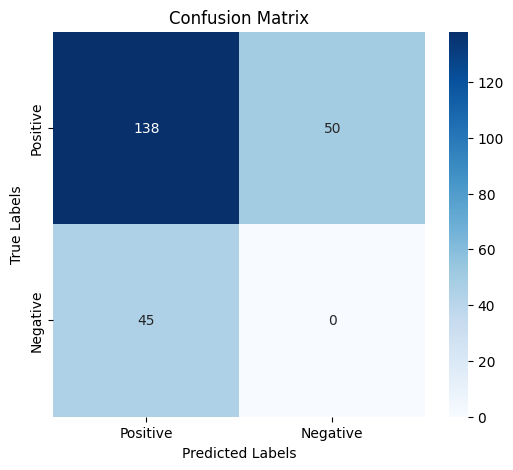

In [16]:
labels = ['Positive', 'Negative']
plt.figure(figsize=(6, 5))
sns.heatmap(
    confusion_matrix, 
    annot=True, 
    fmt="d", 
    cmap="Blues", 
    xticklabels=labels, 
    yticklabels=labels
)

# Add axis labels and title
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [18]:
doc = nlp(test_data[2][0])

displacy.render(doc, style="ent")